In [1]:
from __future__ import print_function, division, absolute_import

import gc

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import numpy as np

In [2]:
from sklearn.datasets import make_moons
x_train, y_train = make_moons(n_samples = 5000, noise = 0.10)
x_test, y_test = make_moons(n_samples = 2000, noise = 0.10)
y_test = y_test.astype(np.float32)
y_train = y_train.astype(np.float32)

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.autograd import Variable

np.random.seed(0)
torch.manual_seed(0)
#torch.cuda.manual_seed(0)

In [4]:
class ConcreteDropout(nn.Module):
    def __init__(self, weight_regularizer=1e-6,
                 dropout_regularizer=1e-5, init_min=0.1, init_max=0.1):
        super(ConcreteDropout, self).__init__()
        
        self.weight_regularizer = weight_regularizer
        self.dropout_regularizer = dropout_regularizer
        
        init_min = np.log(init_min) - np.log(1. - init_min)
        init_max = np.log(init_max) - np.log(1. - init_max)
        
        self.p_logit = nn.Parameter(torch.empty(1).uniform_(init_min, init_max))
        
    def forward(self, x, layer):
        p = torch.sigmoid(self.p_logit)
        
        out = layer(self._concrete_dropout(x, p))
        
        sum_of_square = 0
        for param in layer.parameters():
            sum_of_square += torch.sum(torch.pow(param, 2))
        
        weights_regularizer = self.weight_regularizer * sum_of_square / (1 - p)
        
        dropout_regularizer = p * torch.log(p)
        dropout_regularizer += (1. - p) * torch.log(1. - p)
        
        input_dimensionality = x[0].numel() # Number of elements of first item in batch
        dropout_regularizer *= self.dropout_regularizer * input_dimensionality
        
        regularization = weights_regularizer + dropout_regularizer
        return out, regularization
        
    def _concrete_dropout(self, x, p):
        eps = 1e-7
        temp = 0.1

        unif_noise = torch.rand_like(x)

        drop_prob = (torch.log(p + eps)
                    - torch.log(1 - p + eps)
                    + torch.log(unif_noise + eps)
                    - torch.log(1 - unif_noise + eps))
        
        drop_prob = torch.sigmoid(drop_prob / temp)
        random_tensor = 1 - drop_prob
        retain_prob = 1 - p
        
        x  = torch.mul(x, random_tensor)
        x /= retain_prob
        
        return x


In [5]:
class Model(nn.Module):
    def __init__(self,
                 L,
                 layers,
                 weight_regularizer, dropout_regularizer):
        super(Model, self).__init__()
        
        self.layers = [L]+layers
        self.linear = nn.ModuleList([])
        self.conc_drop = nn.ModuleList([])
        for ii in range(1, len(self.layers)):
            self.linear.append(nn.Linear(self.layers[ii-1], self.layers[ii]))
            self.conc_drop.append(ConcreteDropout(weight_regularizer = weight_regularizer,
                                                  dropout_regularizer = dropout_regularizer))

        self.relu = nn.ReLU()
        
    def forward(self, x):
        regularization = torch.empty(len(self.layers)-1, device=x.device)

        y = x
        for ii in range(1, len(self.layers)):
            y, regularization[ii-1] = self.conc_drop[ii-1](y,
                                                           nn.Sequential(self.linear[ii-1], self.relu))

        return y, regularization.sum()

In [6]:
def loss_function(true, mean):
    return torch.mean(torch.sum((true - mean)**2, 1), 0)

In [7]:
Nepochs = 500
layers = [100, 50, 5, 1]
L = 2
batch_size = 20

In [8]:
def fit_model(layers, Nepochs, x_train, y_train):
    N = x_train.shape[0]
    L = x_train.shape[1]
    l = 1e-4 # length scale
    wr = l**2./N
    dr = 2./N
    model = Model(L, layers, wr, dr)
    #model = model.cuda()
    optimizer = optim.Adam(model.parameters())
    
    for i in range(Nepochs):
        old_batch = 0
        loss_ = 0
        reg_ = 0
        Nbatches = int(np.ceil(N/batch_size))
        pall = np.random.permutation(N)
        for batch in range(Nbatches):
            #p = np.random.choice(N, batch_size)
            p = pall[batch*batch_size : (batch+1)*batch_size]
            _x = x_train[p, :].astype(np.float32)
            _y = y_train[p, np.newaxis].astype(np.float32)
            
            x = torch.as_tensor(_x) #.cuda()
            y = torch.as_tensor(_y) #.cuda()
            
            y_pred, regularization = model(x)
                        
            loss = loss_function(y, y_pred)
            reg = regularization
            loss_total = loss + reg
            
            optimizer.zero_grad()
            loss_total.backward()
            optimizer.step()

            loss_ += loss
            reg_ += reg
            print("Epoch {:>3d}, batch {:>3d}/{:>3d}: loss = {:>5.4f}, mse = {:>5.4f}, reg = {:>5.4f}".format(i,
                                        batch+1, Nbatches,
                                        (loss_+reg_)/float(batch+1), loss_/float(batch+1), reg_/float(batch+1)),
                 end = '\r')


        loss_ /= float(Nbatches)
        reg_ /= float(Nbatches)
        print("Epoch {:>3d}               : loss = {:>5.4f}, mse = {:>5.4f}, reg = {:>5.4f}".format(i,
                                        loss_+reg_, loss_, reg_))
            
    return model

In [9]:
model = fit_model(layers, Nepochs, x_train, y_train)

Epoch   0               : loss = 0.4780, mse = 0.5000, reg = -0.0220
Epoch   1               : loss = 0.4745, mse = 0.5000, reg = -0.0255
Epoch   2               : loss = 0.4709, mse = 0.5000, reg = -0.0291
Epoch   3               : loss = 0.4674, mse = 0.5000, reg = -0.0326
Epoch   4               : loss = 0.4641, mse = 0.5000, reg = -0.0359
Epoch   5               : loss = 0.4615, mse = 0.5000, reg = -0.0385
Epoch   6               : loss = 0.4595, mse = 0.5000, reg = -0.0405
Epoch   7               : loss = 0.3448, mse = 0.3865, reg = -0.0417
Epoch   8               : loss = 0.1157, mse = 0.1573, reg = -0.0416
Epoch   9               : loss = 0.0767, mse = 0.1181, reg = -0.0414
Epoch  10               : loss = 0.0588, mse = 0.1000, reg = -0.0412
Epoch  11               : loss = 0.0440, mse = 0.0850, reg = -0.0410
Epoch  12               : loss = 0.0410, mse = 0.0820, reg = -0.0410
Epoch  13               : loss = 0.0353, mse = 0.0763, reg = -0.0410
Epoch  14               : loss = 0

Epoch 234               : loss = -0.0359, mse = 0.0065, reg = -0.0424
Epoch 235               : loss = -0.0370, mse = 0.0054, reg = -0.0424
Epoch 236               : loss = -0.0388, mse = 0.0036, reg = -0.0424
Epoch 237               : loss = -0.0368, mse = 0.0056, reg = -0.0424
Epoch 238               : loss = -0.0363, mse = 0.0062, reg = -0.0424
Epoch 239               : loss = -0.0386, mse = 0.0039, reg = -0.0424
Epoch 240               : loss = -0.0358, mse = 0.0066, reg = -0.0424
Epoch 241               : loss = -0.0378, mse = 0.0047, reg = -0.0424
Epoch 242               : loss = -0.0395, mse = 0.0029, reg = -0.0425
Epoch 243               : loss = -0.0381, mse = 0.0043, reg = -0.0425
Epoch 244               : loss = -0.0372, mse = 0.0053, reg = -0.0425
Epoch 245               : loss = -0.0380, mse = 0.0045, reg = -0.0425
Epoch 246               : loss = -0.0372, mse = 0.0053, reg = -0.0425
Epoch 247               : loss = -0.0379, mse = 0.0046, reg = -0.0425
Epoch 248           

Epoch 468               : loss = -0.0398, mse = 0.0027, reg = -0.0425
Epoch 469               : loss = -0.0408, mse = 0.0017, reg = -0.0425
Epoch 470               : loss = -0.0394, mse = 0.0031, reg = -0.0425
Epoch 471               : loss = -0.0407, mse = 0.0019, reg = -0.0425
Epoch 472               : loss = -0.0399, mse = 0.0026, reg = -0.0425
Epoch 473               : loss = -0.0398, mse = 0.0027, reg = -0.0425
Epoch 474               : loss = -0.0393, mse = 0.0032, reg = -0.0425
Epoch 475               : loss = -0.0402, mse = 0.0023, reg = -0.0425
Epoch 476               : loss = -0.0400, mse = 0.0025, reg = -0.0425
Epoch 477               : loss = -0.0409, mse = 0.0017, reg = -0.0425
Epoch 478               : loss = -0.0380, mse = 0.0046, reg = -0.0426
Epoch 479               : loss = -0.0387, mse = 0.0038, reg = -0.0426
Epoch 480               : loss = -0.0399, mse = 0.0027, reg = -0.0426
Epoch 481               : loss = -0.0406, mse = 0.0020, reg = -0.0426
Epoch 482           

In [10]:
def getMeanStd(model, x, Npred = 50):
    # per-example predictions
    p = [None]*Npred
    x_ = Variable(torch.FloatTensor(x)) #.cuda()
    for k in range(Npred):
        p[k], regularization = model(x_)
        regularization = regularization.detach()
        del regularization
        p[k] = p[k].detach().numpy()[np.newaxis,...,0]
    p = np.concatenate(p, axis = 0)
    return np.mean(p, axis = 0), np.std(p, axis = 0)

In [11]:
def plot_contour(model, x, y, getFunction):
    # make countour
    mins = [np.min(x[:,0]), np.min(x[:,1])]
    maxs = [np.max(x[:,0]), np.max(x[:,1])]
    step = [(maxs[0] - mins[0])/50.0, (maxs[1] - mins[1])/50.0]
    bx, by = np.mgrid[mins[0]:(maxs[0]+0.5*step[0]):step[0], mins[1]:(maxs[1]+0.5*step[0]):step[1]]
    inputs = np.vstack([bx.flatten(), by.flatten()]).T
    inputs = inputs.astype(np.float32)

    pred_m, pred_s = getFunction(model, inputs, Npred = 50)
    pred_m_2d = pred_m.reshape( (-1, bx.shape[1]) )
    pred_s_2d = pred_s.reshape( (-1, bx.shape[1]) )

    # if one wants to smoothen the results
    #for data in [pred_m_2d, pred_s_2d]:
    #    data = gaussian_filter(data, 0.1)

    fig, ax = plt.subplots(nrows = 2, ncols = 1, sharex = True, figsize = (10, 8))
    cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
    contour_s = ax[0].contourf(bx, by, pred_s_2d, cmap = cmap)
    cbar_s = plt.colorbar(contour_s, ax = ax[0])
    cbar_s.ax.set_ylabel('Unc.')
    contour_m = ax[1].contourf(bx, by, pred_m_2d, cmap = cmap)
    cbar_m = plt.colorbar(contour_m, ax = ax[1])
    cbar_m.ax.set_ylabel('Mean')
    for a in [ax[0], ax[1]]:
        a.scatter(x[y == 1,0], x[y == 1,1], color = 'r', marker = 's', s = 5, label = 'y = 1')
        a.scatter(x[y == 0,0], x[y == 0,1], color = 'b', marker = 's', s = 5, label = 'y = 0')
        a.set(xlabel = 'A', ylabel = 'B', title = '')
        a.set_xlim([mins[0], maxs[0]])
        a.set_ylim([mins[1], maxs[1]])
        a.legend(frameon = True)
    ax[0].set_xlabel('')
    fig.subplots_adjust(hspace = 0)
    fig.tight_layout()
    plt.show()


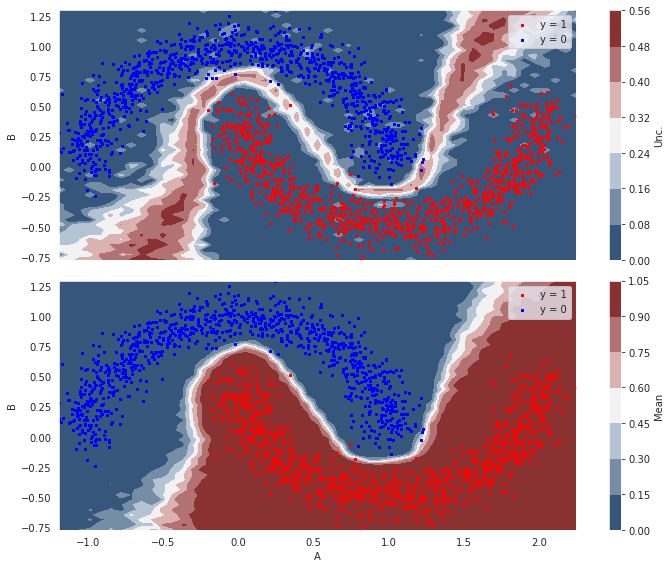

In [12]:
plot_contour(model, x_test, y_test, getFunction = getMeanStd)